In [68]:
import os,sys
import numpy as np
import matplotlib.pyplot as plt
from xspec import *
from scipy.stats import anderson_ksamp, ks_2samp, chisquare
from scipy.interpolate import interp1d
%matplotlib inline

# Configuringe PyXspec settings
AllData.clear()
Xset.abund = "angr"
Xset.xsect = "vern"
Xset.cosmo = "70 0 0.73"
#Xset.delta = 0.01
Fit.statMethod = "cstat"
Fit.method = "leven 10 0.01"
Fit.nIterations = 2000
Plot.xAxis = "keV"

 Solar Abundance Vector set to angr:  Anders E. & Grevesse N. Geochimica et Cosmochimica Acta 53, 197 (1989)
 Cross Section Table set to vern:  Verner, Ferland, Korista, and Yakovlev 1996
Default fit statistic is set to: C-Statistic
   This will apply to all current and newly loaded spectra.


In [69]:
AllData.clear()
Plot.xAxis = "keV"
Plot.device = "/null"  # No interactive plotting
Fit.statMethod = "cstat"

Default fit statistic is set to: C-Statistic
   This will apply to all current and newly loaded spectra.


### Trying CV data with BH model

In [112]:
def Black_Hole_Fit(pha_file):
    spectrum_file = pha_file
    AllData("1:1 " + spectrum_file)
    spec = AllData(1)
    
    AllModels.clear()
    
    bh_model = Model("phabs*powerlaw")
    bh_model.phabs.nH = 0.5
    bh_model.powerlaw.PhoIndex = 2.1
    bh_model.powerlaw.norm = 5.08800E-05
    
    spec.ignore('**-3.0 79.0-**')
    sys.path.append(os.getcwd()+'/..')
    from plot_xspec import PlotXspec
    px = PlotXspec()
    Plot('ldata')
    px.plot_model_and_data(ymin=1e-11,rebinsig=1,rebinbnum=1)
    Fit.statMethod = 'cstat'
    Fit.nIterations = 1000
    Fit.perform()

    cstat_obs = Fit.statistic
    dof = Fit.dof
    num_params = 3  # phabs*mekal has 3 parameters: nH, PhoIndex, norm
    aic = cstat_obs + 2 * num_params
    from scipy.stats import chi2
    p_value = 1 - chi2.cdf(cstat_obs, dof) if dof > 0 else float('nan')

    try:
        Plot("data")  
        data_counts = np.array(Plot.y()) 
        Plot("model")  
        model_counts = np.array(Plot.model()) 
    except Exception as e:
        print(f"Failed to extract counts for test statistics: {str(e)}")
        return

    # Ensure arrays are the same length
    min_len = min(len(data_counts), len(model_counts))
    data_counts = data_counts[:min_len]
    model_counts = model_counts[:min_len]
    
    # Avoid zero counts for statistical tests (add small offset if needed)
    data_counts = np.where(data_counts <= 0, 1e-10, data_counts)
    model_counts = np.where(model_counts <= 0, 1e-10, model_counts)
    
    # Normalize counts to probabilities for Anderson-Darling and KS tests
    data_sum = np.sum(data_counts)
    model_sum = np.sum(model_counts)
    data_norm = data_counts / data_sum
    model_norm = model_counts / model_sum
    
    # Normalize model counts for Pearson Chi-Square test
    model_counts_normalized = model_counts * (data_sum / model_sum) if model_sum > 0 else model_counts
    
    # Compute Anderson-Darling test
    try:
        from scipy import stats
        #ad_stat = anderson_ksamp([data_norm, model_norm], method=stats.PermutationMethod())[0]
        W = np.sum((data_counts - model_counts)**2/(model_counts*(1-model_counts)))
        ad_stat = np.log(W**2)
    except Exception as e:
        print(f"Anderson-Darling test failed: {str(e)}")
        ad_stat = float('inf')
    
    # Compute Kolmogorov-Smirnov test
    try:
        ks_stat = ks_2samp(data_norm, model_norm)[0]
    except Exception as e:
        print(f"Kolmogorov-Smirnov test failed: {str(e)}")
        ks_stat = float('inf')
    
    # Compute Chi-Squared test (manual calculation)
    try:
        chi2_stat = np.sum((data_counts - model_counts)**2 / model_counts)
    except Exception as e:
        print(f"Chi-Squared test failed: {str(e)}")
        chi2_stat = float('inf')
    
    # Compute Pearson Chi-Square test
    try:
        pearson_stat = chisquare(data_counts, model_counts_normalized)[0]
        #pearson_stat = np.sum((data_counts - model_counts)**2 / model_counts)
    except Exception as e:
        print(f"Pearson Chi-Square test failed: {str(e)}")
        pearson_stat = float('inf')
    
    # Print the test statistics
    print("\nTest Statistics for Fit:")
    print(f"Observed C-Statistic: {cstat_obs:.4f}")
    print(f"Degrees of Freedom: {dof}")
    #print(f"AIC (C-Stat): {aic:.4f}")
    print(f"Approximate P-Value (C-Stat): {p_value:.4f}")
    #print(f"Anderson-Darling: {ad_stat:.4f}")
    #print(f"Kolmogorov-Smirnov: {ks_stat:.4f}")
    #print(f"Chi-Squared: {chi2_stat:.4f}")
    #print(f"Pearson Chi-Square: {pearson_stat:.4f}")


Spectrum #: 1 replaced 

1 spectrum  in use
 
Spectral Data File: CV_inf_ks_opt.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  2.038e-03 +/- 1.170e-06 (25.9 % total)
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-541
  Telescope: NuSTAR Instrument: FPMA  Channel Type: PI
  Exposure Time: 1e+10 sec
 Using fit statistic: cstat
 Using Background File                CV_inf_ks_bkg.pha
  Background Exposure Time: 1e+10 sec
 Using Response (RMF) File            nustar.rmf for Source 1
 Using Auxiliary Response (ARF) File  point_30arcsecRad_1arcminOA.arf


Fit statistic  : C-Statistic                248554.8     using 541 bins.

Test statistic : Chi-Squared                358765.0     using 541 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number(s): 1 

 Null hypothesis probability of 0.0e+00 with 538 degrees of freedom
 Current data and model not fit yet.

Model phabs<1>*powerlaw<2> Source No.: 1   Active/On


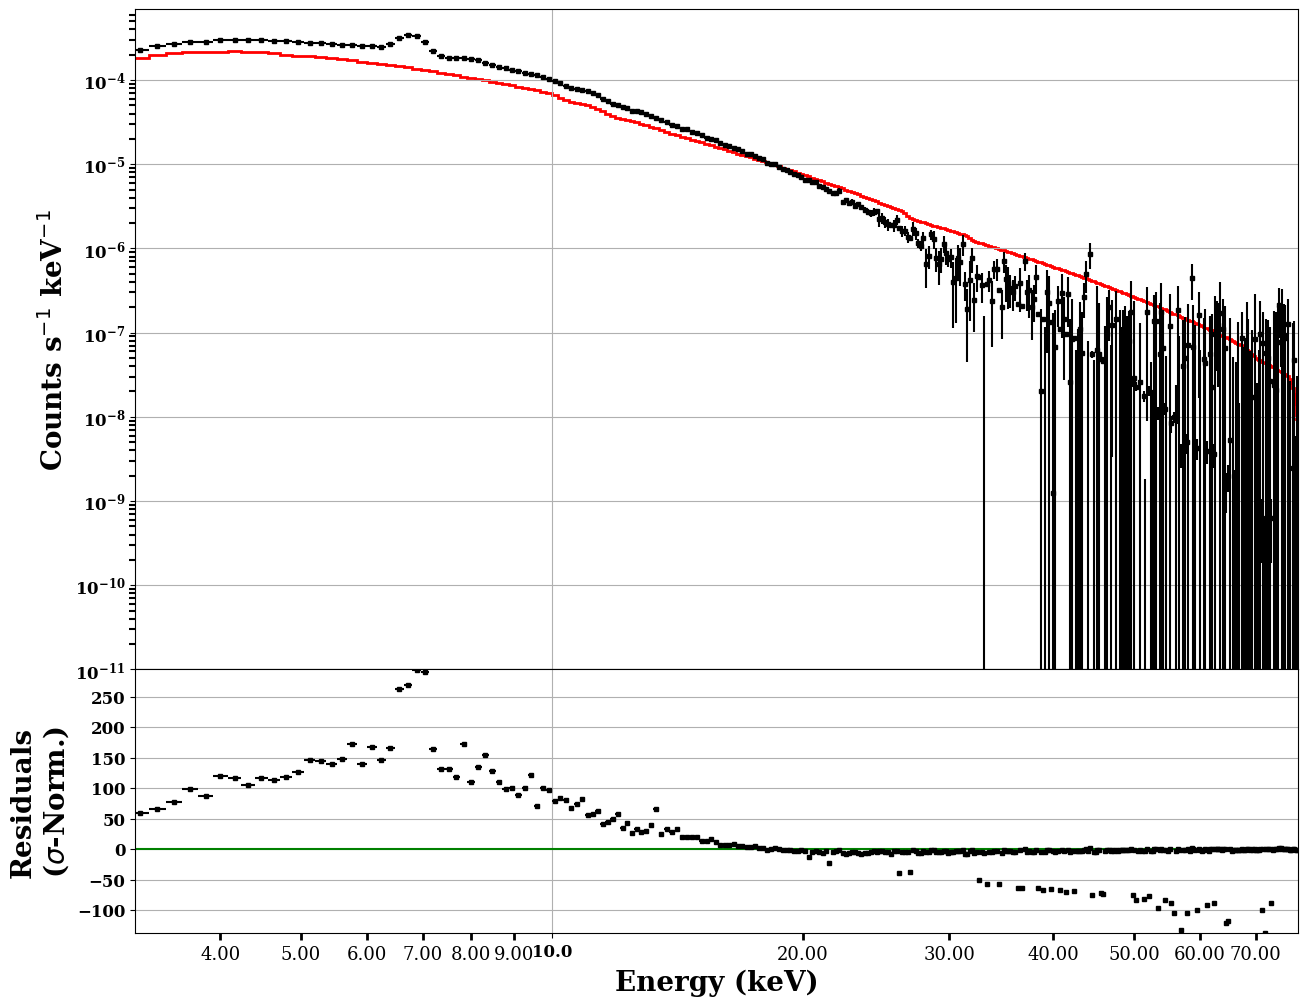

Default fit statistic is set to: C-Statistic
   This will apply to all current and newly loaded spectra.

Fit statistic  : C-Statistic              1.073562e+06     using 333 bins.

Test statistic : Chi-Squared              1.247422e+06     using 333 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number(s): 1 

 Null hypothesis probability of 0.000000e+00 with 330 degrees of freedom
 Current data and model not fit yet.
                                   Parameters
C-Statistic  |beta|/N    Lvl          1:nH    2:PhoIndex        3:norm
473742       1.09743e+10  -2       4.79797       2.28217   9.91542e-05
203380       3.97161e+09  -2       6.07865       2.37894   0.000144109
168003       1.02846e+09  -2       7.23291       2.44409   0.000176416
160845       3.09568e+08  -2       8.00345       2.48981   0.000199671
159748       1.1218e+08   -3       9.30778       2.57222   0.000240470
157244       1.82636e+08  -4       9.49041       2

In [110]:
Black_Hole_Fit("CV_inf_ks_opt.pha")

### Trying BH data with CV model

In [114]:
def Cataclysmic_Variable_Fit(pha_file):
    spectrum_file = pha_file
    AllData("1:1 " + spectrum_file)
    spec = AllData(1)
    
    AllModels.clear()
    
    cv_model = Model("phabs*mekal")
    cv_model.phabs.nH = 0.5
    cv_model.mekal.kT = 10.0
    cv_model.mekal.nH = 0.5
    cv_model.mekal.Abundanc = 0.5
    cv_model.mekal.Redshift = 0
    cv_model.mekal.switch = 0
    cv_model.mekal.norm = 0.000122548
    
    spec.ignore('**-3.0 79.0-**')
    sys.path.append(os.getcwd()+'/..')
    from plot_xspec import PlotXspec
    px = PlotXspec()
    Plot('ldata')
    px.plot_model_and_data(ymin=1e-11,rebinsig=1,rebinbnum=1)
    Fit.statMethod = 'cstat'
    Fit.nIterations = 1000
    Fit.perform()

    # Compute C-statistic, degrees of freedom, AIC, and approximate p-value
    cstat_obs = Fit.statistic
    dof = Fit.dof
    num_params = 7  # phabs*mekal has 7 parameters: nH, PhoIndex, norm
    aic = cstat_obs + 2 * num_params
    from scipy.stats import chi2
    p_value = 1 - chi2.cdf(cstat_obs, dof) if dof > 0 else float('nan')

    try:
        Plot("data")  
        data_counts = np.array(Plot.y()) 
        Plot("model")  
        model_counts = np.array(Plot.model())  
    except Exception as e:
        print(f"Failed to extract counts for test statistics: {str(e)}")
        return

    # Ensure arrays are the same length
    min_len = min(len(data_counts), len(model_counts))
    data_counts = data_counts[:min_len]
    model_counts = model_counts[:min_len]
    
    # Avoid zero counts for statistical tests (add small offset if needed)
    data_counts = np.where(data_counts <= 0, 1e-10, data_counts)
    model_counts = np.where(model_counts <= 0, 1e-10, model_counts)
    
    # Normalize counts to probabilities for Anderson-Darling and KS tests
    data_sum = np.sum(data_counts)
    model_sum = np.sum(model_counts)
    data_norm = data_counts / data_sum
    model_norm = model_counts / model_sum
    
    # Normalize model counts for Pearson Chi-Square test
    model_counts_normalized = model_counts * (data_sum / model_sum) if model_sum > 0 else model_counts
    
    # Compute Anderson-Darling test
    try:
        from scipy import stats
        #ad_stat = anderson_ksamp([data_norm, model_norm], method=stats.PermutationMethod())[0]
        W = np.sum((data_counts - model_counts)**2/(model_counts*(1-model_counts)))
        ad_stat = np.log(W**2)
    except Exception as e:
        print(f"Anderson-Darling test failed: {str(e)}")
        ad_stat = float('inf')
    
    # Compute Kolmogorov-Smirnov test
    try:
        ks_stat = ks_2samp(data_norm, model_norm)[0]
    except Exception as e:
        print(f"Kolmogorov-Smirnov test failed: {str(e)}")
        ks_stat = float('inf')
    
    # Compute Chi-Squared test (manual calculation)
    try:
        chi2_stat = np.sum((data_counts - model_counts)**2 / model_counts)
    except Exception as e:
        print(f"Chi-Squared test failed: {str(e)}")
        chi2_stat = float('inf')
    
    # Compute Pearson Chi-Square test
    try:
        pearson_stat = chisquare(data_counts, model_counts_normalized)[0]
        #pearson_stat = np.sum((data_counts - model_counts)**2 / model_counts)
    except Exception as e:
        print(f"Pearson Chi-Square test failed: {str(e)}")
        pearson_stat = float('inf')
    
    # Print the test statistics
    print("\nTest Statistics for Fit:")
    print(f"Observed C-Statistic: {cstat_obs:.4f}")
    print(f"Degrees of Freedom: {dof}")
    #print(f"AIC (C-Stat): {aic:.4f}")
    print(f"Approximate P-Value (C-Stat): {p_value:.4f}")
    #print(f"Anderson-Darling: {ad_stat:.4f}")
    #print(f"Kolmogorov-Smirnov: {ks_stat:.4f}")
    #print(f"Chi-Squared: {chi2_stat:.4f}")
    #Zznt(f"Pearson Chi-Square: {pearson_stat:.4f}")


Spectrum #: 1 replaced 

1 spectrum  in use
 
Spectral Data File: BH_inf_ks_opt.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.420e-03 +/- 1.143e-06 (19.6 % total)
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-542
  Telescope: NuSTAR Instrument: FPMA  Channel Type: PI
  Exposure Time: 1e+10 sec
 Using fit statistic: cstat
 Using Background File                BH_inf_ks_bkg.pha
  Background Exposure Time: 1e+10 sec
 Using Response (RMF) File            nustar.rmf for Source 1
 Using Auxiliary Response (ARF) File  point_30arcsecRad_1arcminOA.arf


Fit statistic  : C-Statistic              1.016241e+06     using 542 bins.

Test statistic : Chi-Squared              1.083616e+06     using 542 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number(s): 1 

 Null hypothesis probability of 0.000000e+00 with 539 degrees of freedom
 Current data and model not fit yet.

Model phabs<1>*mekal<2> Source No.: 1   Acti

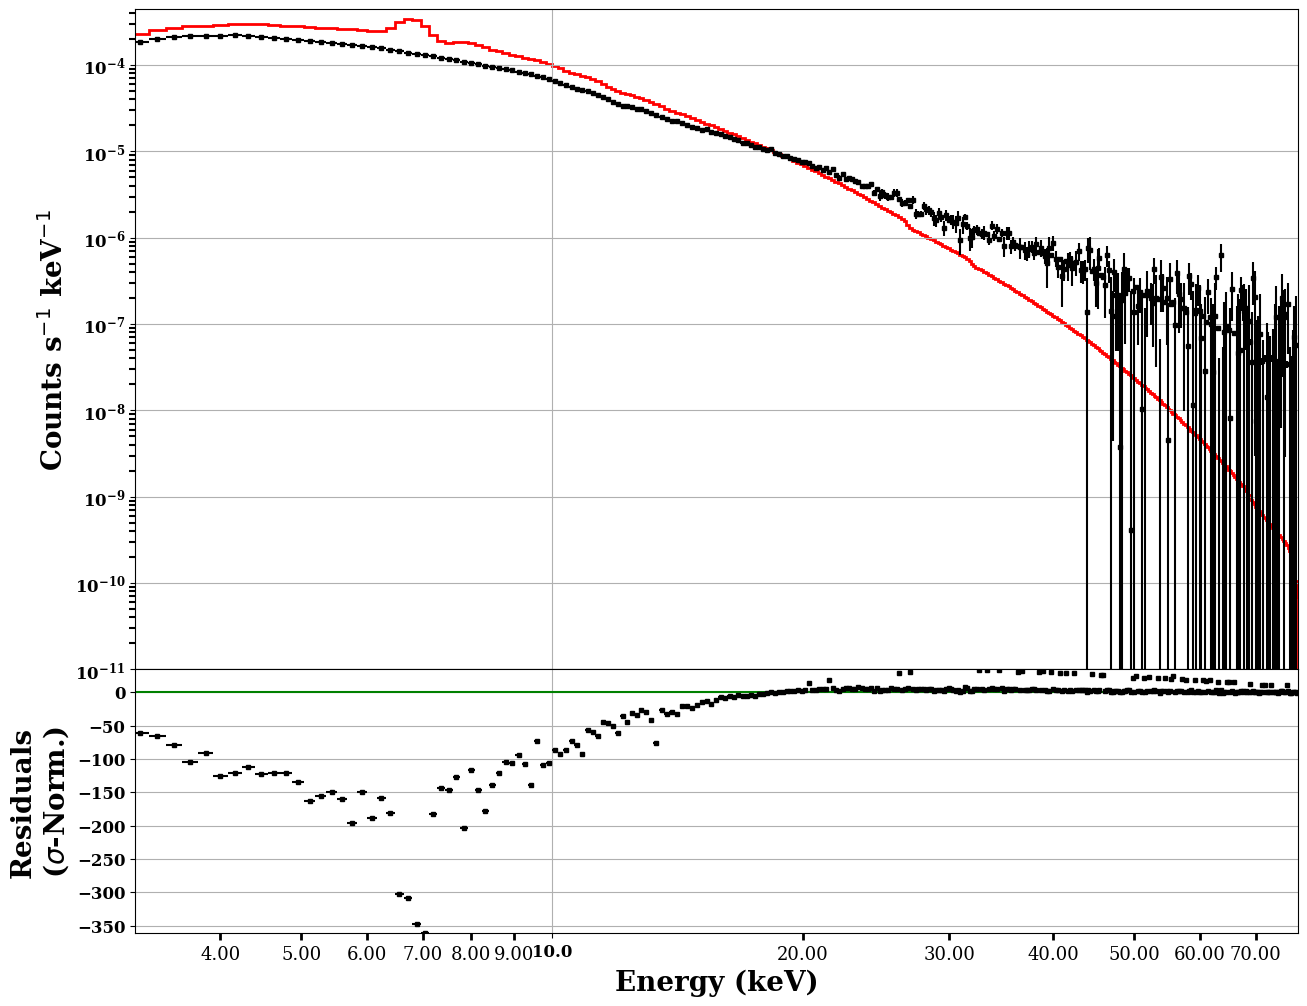

Default fit statistic is set to: C-Statistic
   This will apply to all current and newly loaded spectra.

Fit statistic  : C-Statistic              1.177692e+06     using 334 bins.

Test statistic : Chi-Squared              1.265439e+06     using 334 bins.
 Null hypothesis probability of 0.000000e+00 with 331 degrees of freedom
 Current data and model not fit yet.
                                   Parameters
C-Statistic  |beta|/N    Lvl          1:nH          2:kT        7:norm
852922       7.6971e+09   -2      0.208381       13.4432   4.00595e-05
418701       8.10009e+09  -3     0.0980395       24.9509   4.52163e-05
315138       5.51948e+09  -4    0.00331809       25.8047   4.84793e-05
311649       4.31264e+09  -5   0.000608943       25.9348   4.86034e-05
309433       4.25851e+09  -6   0.000273476       25.8610   4.86930e-05
308466       4.23398e+09  -7   0.000105017       25.7739   4.87348e-05
293616       4.22706e+09  -8   2.67018e-05       25.6872   4.93382e-05
243264       4.0283

In [115]:
Cataclysmic_Variable_Fit("BH_inf_ks_opt.pha")

# Code modified after presentation and comments
### Returns only the statistical results

In [96]:
from scipy.stats import chi2

def extract_model_in_data_range(data_energy, model_energy, model):
    interpolator = interp1d(model_energy, model, kind='linear', fill_value='extrapolate')
    interpolated_model = interpolator(data_energy)
    return interpolated_model


def stats():
    Plot("data")  # Get observed data
    data_counts = np.array(Plot.y())  # Counts/s/keV
    data_err = np.array(Plot.xErr())
    data_energy = np.array(Plot.x())
    Plot("model")  # Get model-predicted counts
    model_counts = np.array(Plot.model())  # Counts/s/keV
    model_energy = np.array(Plot.x())
    
    
    # Ensure arrays are the same length
    model_counts = extract_model_in_data_range(data_energy, model_energy, model_counts)
    
    # Avoid zero counts for statistical tests (add small offset if needed)
    data_counts = np.where(data_counts <= 0, 1e-10, data_counts)
    model_counts = np.where(model_counts <= 0, 1e-10, model_counts)
    data_err = np.where(data_err <= 0, 1e-10, data_err)
    
    # Normalize counts to probabilities for Anderson-Darling and KS tests 
    data_norm = data_counts / np.sum(data_counts)
    model_norm = model_counts / np.sum(model_counts)
    err_norm = data_err / np.sum(data_err)
    Yi = (np.cumsum(data_counts))/(np.sum(data_counts))
    Mi = (np.cumsum(model_counts))/(np.sum(model_counts))
    chisq = np.sum((data_norm - model_norm)**2 / (err_norm**2))
    pchi = np.sum((data_norm - model_norm)**2 / (model_norm))
    ks = np.log(np.max(abs(Yi-Mi)))
    ad = np.log(np.sum(((Yi - Mi)**2)/(abs((Mi*(1-Mi))))))
    cstat = 2 * np.sum(model_counts - data_counts * np.log(model_counts / data_counts), where=(data_counts > 0))
    dof = len(data_norm) - 1  # Approximate degrees of freedom (bins - 1)
    cstat_pval = 1 - chi2.cdf(cstat, dof)
    
    return cstat, cstat_pval, chisq, pchi, ks, ad


In [116]:
def enter_BH_spec(spectrum_file):
    #spectrum_file = "BH_300ks_opt.pha"
    # Load the spectrum
    AllData("1:1 " + spectrum_file)
    spec = AllData(1)
    
    AllModels.clear()
    
    # nH, z, and switch are frozen
    N = 8
    temp = np.linspace(7,13,N)
    Abd = np.linspace(0.1,0.7,N)
    nor = np.linspace(0.00001, 0.0002, N)
    cstat = []
    cstat_index = []
    cstat_pval = []
    cstat_pval_index = []
    chisq = []
    chisq_index = []
    ad = []
    ad_index = []
    ks = []
    ks_index = []
    pchi = []
    pchi_index = []
    #
    
    
        
    for i in temp:
        for j in Abd:
            for k in nor:
                cv_model = Model("phabs*mekal")
                cv_model.phabs.nH = 0.5
                cv_model.mekal.kT = i
                cv_model.mekal.nH = 0.5
                cv_model.mekal.Abundanc = j
                cv_model.mekal.Redshift = 0
                cv_model.mekal.switch = 0
                cv_model.mekal.norm = k
                cstat.append(stats()[0])
                cstat_index.append((i,j,k))
                cstat_pval.append(stats()[1])
                cstat_pval_index.append((i,j,k))
                chisq_index.append((i,j,k))
                chisq.append(stats()[2])
                chisq_index.append((i,j,k))
                pchi.append(stats()[3])
                pchi_index.append((i,j,k))
                ks.append(stats()[4])
                ks_index.append((i,j,k))
                ad.append(stats()[5])
                ad_index.append((i,j,k))
    
    
    spec.ignore('**-3.0 79.0-**')
    #sys.path.append(os.getcwd()+'/..')
    
    
    print("The Chi-squared statistics was minimum at ",np.min(chisq))
    print("And the best fit parameters corresponding to this value are:")
    print("phabs nH = 0.5")
    print("mekal kT = ", chisq_index[np.where(chisq==np.min(chisq))[0][0]][0])
    print("mekal nH = 0.5")
    print("mekal abundance = ",chisq_index[np.where(chisq==np.min(chisq))[0][0]][1])
    print("mekal redshift = 0")
    print("mekal switch = 0")
    print("mekal norm = ", chisq_index[np.where(chisq==np.min(chisq))[0][0]][2])
    
    print("------------------------------------------------------------------------------------------------------------------------")
    print("The Pearson chi-squared statistics was minimum at ",np.min(pchi))
    print("And the best fit parameters corresponding to this value are:")
    print("phabs nH = 0.5")
    print("mekal kT = ", pchi_index[np.where(pchi==np.min(pchi))[0][0]][0])
    print("mekal nH = 0.5")
    print("mekal abundance = ",pchi_index[np.where(pchi==np.min(pchi))[0][0]][1])
    print("mekal redshift = 0")
    print("mekal switch = 0")
    print("mekal norm = ", pchi_index[np.where(pchi==np.min(pchi))[0][0]][2])
    
    print("------------------------------------------------------------------------------------------------------------------------")
    print("The Anderson Darling statistics was minimum at ",np.min(ad))
    print("And the best fit parameters corresponding to this value are:")
    print("phabs nH = 0.5")
    print("mekal kT = ", ad_index[np.where(ad==np.min(ad))[0][0]][0])
    print("mekal nH = 0.5")
    print("mekal abundance = ",ad_index[np.where(ad==np.min(ad))[0][0]][1])
    print("mekal redshift = 0")
    print("mekal switch = 0")
    print("mekal norm = ", ad_index[np.where(ad==np.min(ad))[0][0]][2])
    
    print("------------------------------------------------------------------------------------------------------------------------")
    print("The Kolmogorov-Smirnov statistics was minimum at ",np.min(ks))
    print("And the best fit parameters corresponding to this value are:")
    print("phabs nH = 0.5")
    print("mekal kT = ", ks_index[np.where(ks==np.min(ks))[0][0]][0])
    print("mekal nH = 0.5")
    print("mekal abundance = ",ks_index[np.where(ks==np.min(ks))[0][0]][1])
    print("mekal redshift = 0")
    print("mekal switch = 0")
    print("mekal norm = ", ks_index[np.where(ks==np.min(ks))[0][0]][2])

    print("The C-statistics was maximum at ",np.min(cstat))
    print("The p-value was maximum at ",np.max(cstat_pval))
    print("The Chi-squared statistics was minimum at ",np.min(chisq))
    print("The Pearson chi-squared statistics was minimum at ",np.min(pchi))
    print("The Anderson Darling statistics was minimum at ",np.min(ad))
    print("The Kolmogorov-Smirnov statistics was minimum at ",np.min(ks))


In [100]:
enter_BH_spec("BH_30ks_opt.pha")


Spectrum #: 1 replaced 

1 spectrum  in use
 
Spectral Data File: BH_30ks_opt.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  6.667e-04 +/- 6.498e-04 (10.0 % total)
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-218
  Telescope: NuSTAR Instrument: FPMA  Channel Type: PI
  Exposure Time: 3e+04 sec
 Using fit statistic: cstat
 Using Background File                BH_30ks_bkg.pha
  Background Exposure Time: 3e+04 sec
 Using Response (RMF) File            nustar.rmf for Source 1
 Using Auxiliary Response (ARF) File  point_30arcsecRad_1arcminOA.arf


Fit statistic  : C-Statistic                  251.65     using 218 bins.

Test statistic : Chi-Squared                  252.93     using 218 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number(s): 1 

 Null hypothesis probability of 3.89e-02 with 215 degrees of freedom
 Current data and model not fit yet.

Model phabs<1>*mekal<2> Source No.: 1   Active/On
Model 

/tmp/ipykernel_7091/2794782051.py:36: RuntimeWarning: divide by zero encountered in divide
  ad = np.log(np.sum(((Yi - Mi)**2)/(abs((Mi*(1-Mi))))))



Fit statistic  : C-Statistic                711024.7     using 218 bins.

Test statistic : Chi-Squared              1.184117e+09     using 218 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number(s): 1 

 Null hypothesis probability of 0.000000e+00 with 215 degrees of freedom
 Current data and model not fit yet.

Fit statistic  : C-Statistic                  207.49     using 218 bins.

Test statistic : Chi-Squared                  172.59     using 218 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number(s): 1 

 Null hypothesis probability of 9.85e-01 with 215 degrees of freedom
 Current data and model not fit yet.
***Warning: Fit is not current.
***Warning: Fit is not current.
***Warning: Fit is not current.
***Warning: Fit is not current.
***Warning: Fit is not current.
***Warning: Fit is not current.

Model phabs<1>*mekal<2> Source No.: 1   Active/On
Model Model Component

In [118]:
def enter_CV_spec(spectrum_file):
    # Load the spectrum
    AllData("1:1 " + spectrum_file)
    spec = AllData(1)
    
    AllModels.clear()

    """bh_model = Model("phabs*powerlaw")
    bh_model.phabs.nH = 0.5
    bh_model.powerlaw.PhoIndex = 2.1
    bh_model.powerlaw.norm = 5.08800E-05"""

    # nH is frozen
    N = 10
    gamma = np.linspace(1.8,2.3,N)
    nor = np.linspace(3.08800E-05, 7.08800E-05, N)
    chisq = []
    chisq_index = []
    ad = []
    ad_index = []
    ks = []
    ks_index = []
    pchi = []
    pchi_index = []
    #
    
    
    
    for i in gamma:
        for j in nor:
            bh_model = Model("phabs*powerlaw")
            bh_model.phabs.nH = 0.5
            bh_model.powerlaw.PhoIndex = i
            bh_model.powerlaw.norm = j
            chisq.append(stats()[0])
            chisq_index.append((i,j))
            pchi.append(stats()[1])
            pchi_index.append((i,j))
            ks.append(stats()[2])
            ks_index.append((i,j))
            ad.append(stats()[3])
            ad_index.append((i,j))
    
    
    spec.ignore('**-3.0 79.0-**')
    #sys.path.append(os.getcwd()+'/..')
    
    print("\n")
    print("\n")
    print("\n")
    print("The Chi-squared statistics was minimum at ",np.min(chisq))
    print("And the best fit parameters corresponding to this value are:")
    print("phabs nH = 0.5")
    print("powerlaw photon-index = ", chisq_index[np.where(chisq==np.min(chisq))[0][0]][0])
    print("powerlaw norm = ", chisq_index[np.where(chisq==np.min(chisq))[0][0]][1])
    
    print("------------------------------------------------------------------------------------------------------------------------")
    print("The Pearson chi-squared statistics was minimum at ",np.min(pchi))
    print("And the best fit parameters corresponding to this value are:")
    print("phabs nH = 0.5")
    print("powerlaw photon-index = ", pchi_index[np.where(pchi==np.min(pchi))[0][0]][0])
    print("powerlaw norm = ", pchi_index[np.where(pchi==np.min(pchi))[0][0]][1])
    
    print("------------------------------------------------------------------------------------------------------------------------")
    print("The Anderson Darling statistics was minimum at ",np.min(ad))
    print("And the best fit parameters corresponding to this value are:")
    print("phabs nH = 0.5")
    print("powerlaw photon-index = ", ad_index[np.where(ad==np.min(ad))[0][0]][0])
    print("powerlaw norm = ", ad_index[np.where(ad==np.min(ad))[0][0]][1])
    
    print("------------------------------------------------------------------------------------------------------------------------")
    print("The Kolmogorov-Smirnov statistics was minimum at ",np.min(ks))
    print("And the best fit parameters corresponding to this value are:")
    print("phabs nH = 0.5")
    print("powerlaw photon-index = ", ks_index[np.where(ks==np.min(ks))[0][0]][0])
    print("powerlaw norm = ", ks_index[np.where(ks==np.min(ks))[0][0]][1])
    print("\n")
    print("\n")
    print("\n")


In [92]:
enter_CV_spec("CV_inf_ks_opt.pha")


Spectrum #: 1 replaced 

1 spectrum  in use
 
Spectral Data File: CV_inf_ks_opt.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  2.038e-03 +/- 1.170e-06 (25.9 % total)
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-541
  Telescope: NuSTAR Instrument: FPMA  Channel Type: PI
  Exposure Time: 1e+10 sec
 Using fit statistic: cstat
 Using Background File                CV_inf_ks_bkg.pha
  Background Exposure Time: 1e+10 sec
 Using Response (RMF) File            nustar.rmf for Source 1
 Using Auxiliary Response (ARF) File  point_30arcsecRad_1arcminOA.arf


Fit statistic  : C-Statistic              1.240907e+06     using 541 bins.

Test statistic : Chi-Squared              1.253176e+06     using 541 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number(s): 1 

 Null hypothesis probability of 0.000000e+00 with 538 degrees of freedom
 Current data and model not fit yet.

Model phabs<1>*powerlaw<2> Source No.: 1   A

/tmp/ipykernel_7091/1512305574.py:34: RuntimeWarning: divide by zero encountered in divide
  ad = np.log(np.sum(((Yi - Mi)**2)/(abs((Mi*(1-Mi))))))



Fit statistic  : C-Statistic              8.937611e+11     using 541 bins.

Test statistic : Chi-Squared              4.270807e+15     using 541 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number(s): 1 

 Null hypothesis probability of 0.000000e+00 with 538 degrees of freedom
 Current data and model not fit yet.

Fit statistic  : C-Statistic                536812.9     using 541 bins.

Test statistic : Chi-Squared              2.668839e+06     using 541 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number(s): 1 

 Null hypothesis probability of 0.000000e+00 with 538 degrees of freedom
 Current data and model not fit yet.
***Warning: Fit is not current.
***Warning: Fit is not current.
***Warning: Fit is not current.
***Warning: Fit is not current.

Model phabs<1>*powerlaw<2> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   ph